# Deep Reinforcement Lerning Lectures - Policy Gradients

### Imports and auxiliary settings

In [1]:
!apt update
!apt install -y xvfb x11-utils python3-opengl ffmpeg swig
!pip install swig
!pip install jax==0.4.13 jaxlib==0.4.13
!pip install gymnasium==0.27.1 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1
!pip install seaborn

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]    
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2512 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2439 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1885 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.7 kB]3m
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1088 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multi

In [1]:
# select device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader

# Cross Framework library for DL
import onnx
from onnx2pytorch import ConvertModel

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
import copy
import glob
from time import time, strftime
from tqdm import tqdm
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

# Environment import and set logger level to display error only
# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import HTML, display, clear_output

# start virtual display
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(640, 480))
pydisplay.start()

/usr/local/lib/python3.11/dist-packages/gymnasium/experimental/wrappers/jax_to_numpy.py:75: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  @jax_to_numpy.register(jnp.DeviceArray)
/usr/local/lib/python3.11/dist-packages/gymnasium/experimental/wrappers/jax_to_torch.py:105: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  @jax_to_torch.register(jnp.DeviceArray)


In [3]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Auxiliary Methods

In [4]:
class Logger(object):
    """Logger that can be used for debugging different values
    """
    def __init__(self, logdir, params=None, debug=False):
        self.gradients = []
        self.debug = debug
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    def add_gradients(self, grad):
        if not self.debug: return
        self.gradients.append(grad)

    def compute_gradient_variance(self):
        vars_ = []
        grads_list = [np.zeros_like(self.gradients[0])] * 100
        for i, grads in enumerate(self.gradients):
            grads_list.append(grads)
            grads_list = grads_list[1:]
            grad_arr = np.stack(grads_list, axis=0)
            g = np.apply_along_axis(grad_variance, axis=-1, arr=grad_arr)
            vars_.append(np.mean(g))
        return vars_

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")

    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))

    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None

    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i

In [5]:
def wrap_env(env, logger, capture_video=True):
    # wrapper for recording
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir, episode_trigger=lambda idx: True)
    return env


def create_env(logger, env_id='BipedalWalker-v3', hardcore=False, capture_video=True):
    # initialize environment
    env = wrap_env(gym.make(env_id, max_episode_steps=400, hardcore=hardcore, render_mode="rgb_array"),
                   logger=logger,
                   capture_video=capture_video)
    action_size = env.action_space.shape[0]
    state_size = env.observation_space.shape[0]
    return env, action_size, state_size


def set_seed(env, seed=None):
    # seeding the envrionment
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


def transforms(state):
    # transofrm to numpy to tensor and push to device
    return torch.FloatTensor(state).to(device)


def test_environment(env, agent=None, seed=42, n_steps=200):
    # run and evaluate in the environment
    state, info = env.reset(seed=seed)
    for i in range(n_steps):
        env.render()

        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent.act(state)
            action = action.squeeze().cpu().numpy()
        state, reward, done, truncated, info = env.step(action)
        if done:
            state, info = env.reset(seed=seed)
    env.close()


def get_running_stat(stat, stat_len):
    # evaluate stats
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len


def plot_results(runner):
    # plot stats
    episode, r, l = np.array(runner.stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    plt.figure(figsize=(16, 16))

    plt.subplot(321)

    # plot rewards
    plt.plot(episode[-len(cum_r):], cum_r)
    plt.plot(episode, r, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')

    plt.subplot(322)

    # plot episode lengths
    plt.plot(episode[-len(cum_l):], cum_l)
    plt.plot(episode, l, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')

    plt.subplot(323)

    # plot return
    all_returns = np.array(runner.buffer.all_returns)
    plt.scatter(range(0, len(all_returns)), all_returns, alpha=0.5)
    mean_returns = np.array(runner.buffer.mean_returns)
    plt.plot(range(0, len(mean_returns)), mean_returns, color="orange")
    plt.xlabel('Episode')
    plt.ylabel('Return')

    plt.subplot(324)

    # plot entropy
    entropy_arr = np.array(runner.stats_entropy_list)
    plt.plot(range(0, len(entropy_arr)), entropy_arr)
    plt.xlabel('Episode')
    plt.ylabel('Entropy')

    plt.subplot(325)

    if runner.logger.debug:
        # plot variance
        variance_arr = np.array(runner.logger.compute_gradient_variance())
        plt.plot(range(0, len(variance_arr)), variance_arr)
        plt.xlabel('Episode')
        plt.ylabel('Variance')

    plt.show()


"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(logger):
    print(logger.video_dir)
    mp4list = glob.glob(f'{logger.video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def grad_variance(g):
    # compute gradient variance
    return np.mean(g**2) - np.mean(g)**2

### Test environment

OpenAI offers a set of environments for Reinforcement Learning, which are accessible via the `gymnasium` pip package.
In this exercise we will focus on discrete control tasks using a Box2D simulation known as BipedalWalker-v3.
To access the Box2D packages, we use the gymnasium pypi `box2d` option.

In [6]:
# show behavior in envrionment with random agent
logger = Logger("logdir")
env, _, _ = create_env(logger)
test_environment(env)
show_video(logger)

Moviepy - Building video /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-0.mp4
Moviepy - Building video /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-1.mp4
Moviepy - Building video /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-14T12-19-14/videos/rl-video-episode-2.mp4
logdir/2024-06-14T12-19-14/videos


### Training Buffer

In [7]:
class Transition(object):
    """Transition helper object
    """
    def __init__(self, state, action, reward, next_state, log_probs):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.g_return = 0.0
        self.log_probs = log_probs


class Episode(object):
    """Class for collecting an episode of transitions
    """
    def __init__(self, discount):
        self.discount = discount
        self._empty()
        self.total_reward = 0.0

    def _empty(self):
        self.n = 0
        self.transitions = []

    def reset(self):
        self._empty()

    def size(self):
        return self.n

    def append(self, transition):
        self.transitions.append(transition)
        self.n += 1

    def states(self):
        return [s.state for s in self.transitions]

    def actions(self):
        return [a.action for a in self.transitions]

    def rewards(self):
        return [r.reward for r in self.transitions]

    def next_states(self):
        return [s_.next_state for s_ in self.transitions]

    def returns(self):
        return [r.g_return for r in self.transitions]

    def calculate_return(self):
        # calculate the return of the episode
        rewards = self.rewards()
        trajectory_len = len(rewards)
        return_array = torch.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1, -1, -1):
            g_return = rewards[i] + self.discount*g_return
            return_array[i] = g_return
            self.transitions[i].g_return = g_return
        return return_array


class BufferDataset(Dataset):
    """Buffer dataset used to iterate over buffer samples when training.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]
        return t.state, t.action, t.reward, t.next_state, t.log_probs


class RolloutBuffer(object):
    # ===================================================
    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
    # ===================================================
    # > feel free to optimize sampling and buffer handling
    # ===================================================
    """Buffer to collect samples while rolling out in the envrionment.
    """
    def __init__(self, capacity, batch_size, min_transitions):
        self.capacity = capacity
        self.batch_size = batch_size
        self.min_transitions = min_transitions
        self.buffer = []
        self._empty()
        self.mean_returns = []
        self.all_returns = []

    def _empty(self):
        # empty the buffer
        del self.buffer[:]
        self.position = 0

    def add(self, episode):
        # Saves a transition
        episode.calculate_return()
        for t in episode.transitions:
            if len(self.buffer) < self.capacity:
                self.buffer.append(None)
            self.buffer[self.position] = t
            self.position = (self.position + 1) % self.capacity

    def update_stats(self):
        # update the statistics on the buffer
        returns = [t.g_return for t in self.buffer]
        self.all_returns += returns
        mean_return = np.mean(np.array(returns))
        self.mean_returns += ([mean_return]*len(returns))

    def reset(self):
        # calls empty
        self._empty()

    def create_dataloader(self):
        # creates a dataloader for training
        train_loader = DataLoader(
            BufferDataset(self.buffer),
            batch_size=self.batch_size,
            shuffle=True
        )
        return train_loader

    def __len__(self):
        return len(self.buffer)

### Define Models

In [197]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorNet(nn.Module):
    """Actor network (policy)
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.fc1 = layer_init(nn.Linear(state_size, hidden_size))
        self.fc2 = layer_init(nn.Linear(hidden_size, hidden_size))
        self.mu_layer = layer_init(nn.Linear(hidden_size, action_size),std=0.01)
        self.sigma_layer = layer_init(nn.Linear(hidden_size, action_size), std=0.01)


    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        mu = self.mu_layer(x)
        sigma = self.sigma_layer(x) 
        return mu, sigma



class CriticNet(nn.Module):
    """Critic network computing the state value
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.fc1 = layer_init(nn.Linear(state_size, hidden_size))
        self.fc2 = layer_init(nn.Linear(hidden_size, hidden_size))
        self.fc3 = layer_init(nn.Linear(hidden_size, 1))


    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
        


class ActorCriticNet(nn.Module):
    """Combining both networks and add helper methods to act and evaluate samples.
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorCriticNet, self).__init__()
        self.actor = ActorNet(state_size, action_size, hidden_size)
        self.critic = CriticNet(state_size, action_size, hidden_size)

    def forward(self, x):
        x = x.reshape(1, -1)
        return self.act(x)

    def act(self, state):

        # 1) get mean and sigma logits
        mu,sigma = self.actor(state)
        mu = F.tanh(mu)

        # 2) softplus the sigma logits to ensure only positive values
        sigma = F.softplus(sigma) + 1e-5
        # 3) create a Normal distribution based on mu and sigma
        normal_distr = Normal(mu, sigma)
        # 4) sample from the distribution
        action = normal_distr.sample().squeeze()
        action = torch.clamp(action, -1, 1)
        # 5) get log probabilities
        log_probs = normal_distr.log_prob(action)

        return action, log_probs

    def evaluate(self, state, action):

        # 1) get mean and sigma logits
        mu,sigma = self.actor(state)
        mu = F.tanh(mu)
        # 2) softplus the sigma logits to ensure only positive values
        sigma = F.softplus(sigma) + 1e-5
        # 3) create a Normal distribution based on mu and sigma
        normal_distr = Normal(mu, sigma)
        # 4) get log probabilities
        log_probs = normal_distr.log_prob(action)
        # 5) get entropy from the distribution
        entropy = normal_distr.entropy()
        # 6) evaluate state value
        state_value = self.critic(state)

        return state_value, log_probs, entropy

### Define Agent

In [198]:
class Agent(object):
    """Agent class used for training, saving data and handling the model.
    """
    def __init__(self, buffer, state_size, action_size, hidden_size, lr_actor,lr_critic, logger, eps_clip, n_epochs,
                 weight_decay, betas, loss_scales, discount, checkpoint_dir="ckpts"):
        self.action_size = action_size
        self.state_size = state_size
        self.buffer = buffer
        self.checkpoint_dir = checkpoint_dir
        self.loss_scales = loss_scales
        self.n_epochs = n_epochs
        self.eps_clip = eps_clip
        self.logger = logger
        self.discount = discount
        self.model = ActorCriticNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.model.actor.parameters(), 'lr': lr_actor,'weight_decay':weight_decay,'betas':betas,'eps':1e-5},
                        {'params': self.model.critic.parameters(), 'lr': lr_critic,'weight_decay':weight_decay,'betas':betas,'eps':1e-5}
                    ])

        self.critic_criterion = torch.nn.MSELoss()


    def save_checkpoint(self, epoch, info=''):
        """Saves a model checkpoint"""
        state = {
            'info': info,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        ckp_name = 'best-checkpoint.pth' if info == 'best' else f'checkpoint-epoch{epoch}.pth'
        filename = os.path.join(self.checkpoint_dir, ckp_name)
        torch.save(state, filename)

    def resume_checkpoint(self, resume_path):
        """Resumes training from an existing model checkpoint"""
        checkpoint = torch.load(resume_path)
        # load architecture params from checkpoint.
        self.model.load_state_dict(checkpoint['state_dict'])
        # load optimizer state from checkpoint only when optimizer type is not changed.
        self.optimizer.load_state_dict(checkpoint['optimizer'])

    def load_onnx_checkpoint(self, onnx_file):
        self.model.actor = ConvertModel(onnx.load(onnx_file)).to(device)
        self.model.eval()

    def save_onnx_checkpoint(self):
        """Create an ONNX checkpoint"""
        dummy_input = torch.randn((1, self.state_size))
        dummy_input_t = transforms(dummy_input).to(device)
        model = agent.model.actor.to(device)
        torch.onnx.export(model, dummy_input_t, "submission_actor.onnx", verbose=False, opset_version=10, export_params=True, do_constant_folding=True)

    def check(self, file_name):
        # Load the ONNX model
        model = onnx.load(file_name)
        # Check that the IR is well formed
        onnx.checker.check_model(model)

    def act(self, state):
        with torch.no_grad():
            state_t = transforms(state).unsqueeze(0)
            action, log_probs = self.model.act(state_t)
        return action.cpu(), log_probs

    def train(self):
        for i in range(self.n_epochs):
            # create the a dataloader based on the current buffer
            loader = self.buffer.create_dataloader()
            # iterate over the samples in the dataloader
            for states, actions, rewards, next_states, old_log_probs in loader:

                rewards = rewards.to(torch.float32).to(device)
                if rewards.shape[0] > 1:
                    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

                rewards =  torch.clamp(rewards, -10, 10) 
                
                states, actions, rewards, next_states = states.to(device), actions.to(device), rewards.to(device), next_states.to(device)
                old_log_probs = old_log_probs.squeeze().to(device).detach()
               
                with torch.no_grad(): 
                    # 1) compute target value with next state and reward
                    next_state_values = self.model.critic(next_states).squeeze()
                    target_values = rewards + self.discount * next_state_values

                # 2) compute advantage function from target and current state and action
                state_values, log_probs, entropy = self.model.evaluate(states, actions)
                state_values = state_values.squeeze()
                with torch.no_grad(): 
                    advantages = (target_values - state_values)
                    if advantages.numel() > 1:
                        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

                # 3) compute importance sampling ratio from log probabilities
                if(len(old_log_probs.shape) == 1):
                    old_log_probs = old_log_probs.unsqueeze(0)

                ratio = (log_probs.sum(1)  - old_log_probs.sum(1)).exp()



                # 4) compute surrogate loss with the advantage and clipped surrogate loss
                sur1 = ratio * advantages
                sur2 = torch.clamp(ratio,1 - self.eps_clip, 1 + self.eps_clip) * advantages
                #print(torch.min(sur1,sur2).shape)
                policy_loss = - torch.min(sur1,sur2)

                # 5) compute value losses
                value_loss = self.critic_criterion(state_values,target_values)
                entropy_loss = entropy.sum(1)

                # 6) compute total loss with entropy regularization
                loss = self.loss_scales[0] * value_loss + self.loss_scales[1] * policy_loss - self.loss_scales[2] * entropy_loss

                # 7) compute gradients and perform optimization step
                self.optimizer.zero_grad()
                loss.mean().backward()
                self.logger.add_gradients(np.concatenate([param.grad.view(-1).detach().cpu().numpy() for param in self.model.parameters()], axis=0))
                torch.nn.utils.clip_grad_norm_(self.model.actor.parameters(), max_norm=0.5)
                torch.nn.utils.clip_grad_norm_(self.model.critic.parameters(), max_norm=0.5)
                self.optimizer.step()

        # return losses and entropy
        return (loss.mean().detach().cpu().numpy(),
                value_loss.mean().detach().cpu().numpy(),
                policy_loss.mean().detach().cpu().numpy()), entropy.mean().detach().cpu().numpy()

### Define Task Runner

In [199]:
class Runner(object):
    """Runner class performing the rollout in the environment and calling the agent training function periodically
    """
    def __init__(self, env, agent, buffer, logger, discount=0.99, n_episodes=4000, reward_scale=lambda x: x,
                 use_buffer_reset=True, stats_interval=1, print_stats=True, min_average_reward=300, render=False, seed=42, checkpoint_interval=100, max_episode_steps=2000):
        self.env = env
        self.agent = agent
        self.buffer = buffer
        self.render = render
        self.logger = logger
        self.discount = discount
        self.n_episodes = n_episodes
        self.reward_scale = reward_scale
        self.use_buffer_reset = use_buffer_reset
        self.stats_interval = stats_interval
        self.print_stats = print_stats
        self.min_average_reward = min_average_reward
        self.seed = seed
        self.max_episode_steps = max_episode_steps
        # store stats for plotting
        self.stats_rewards_list = []
        self.stats_entropy_list = []
        # stats for running episodes
        self.timesteps = 0
        self.checkpoint_interval = checkpoint_interval
        self.best_model = None
        self.max_reward = -np.inf

    def run(self):
        #self.agent.model.eval()
        # train for n episodes
        with tqdm(range(self.n_episodes)) as pbar:
            self.agent.model.eval()
            for e in pbar:
                # reset env and stats
                state, info = self.env.reset(seed=self.seed)
                total_losses = 0.
                value_losses = 0.
                policy_losses = 0.

                # create new episode
                episode = Episode(discount=self.discount)

                # save model
                if e % self.checkpoint_interval == 0:
                    self.agent.save_checkpoint(e)

                done = False
                # train in each episode until episode is done
                while not done:
                    self.timesteps += 1
                    # render env
                    if self.render: self.env.render()

                    # 1) get action and log_probs
                    action, log_probs =  self.agent.act(state)

                    # 2) step in the environment to collect transitions
                    next_state, reward, done, truncated,_ = self.env.step(action.numpy())
                    episode.total_reward += reward

                    transition = Transition(state=state, action=action, next_state = next_state, reward=(reward*self.reward_scale), log_probs=log_probs)
                    episode.append(transition)

                    # 3) uptade agent when buffer has sufficient samples

                    if done or episode.size() > self.max_episode_steps:
                        # add current episode to the replay buffer
                        done = True
                        self.buffer.add(episode)
                        self.stats_rewards_list.append((e, episode.total_reward, episode.size()))

                        # skip if stored episodes are less than the batch size
                        if len(self.buffer) < self.buffer.min_transitions: break

                        # update the network
                        self.agent.model.train()
                        (total_loss, value_loss, policy_loss), entropy = self.agent.train()


                    # 4) log statistics and reset buffer

                        total_losses += total_loss
                        value_losses += value_loss
                        policy_losses += policy_loss
                        self.stats_entropy_list.append(entropy)
                        self.buffer.update_stats()

                        if self.use_buffer_reset: self.buffer.reset()
                        if self.print_stats and e % self.stats_interval == 0:
                            pbar.set_description("[%03d] Reward: %.4f" % (e, np.mean(self.stats_rewards_list[-self.stats_interval:],axis=0)[1]))

                        #episode.reset()


                    state = next_state

                # save best model
                if self.best_model is None or episode.total_reward > self.max_reward:
                    self.best_model = copy.deepcopy(self.agent.model)
                    self.agent.save_checkpoint(e, 'best')
                    self.max_reward = episode.total_reward

### Train Agent

This is a where you run your actor-critic PPO algorithm.

Some tips as to what you need to implement:
- chose proper architectures for the actor-critic networks
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

In [211]:
# create environment
logger = Logger("logdir")
env, action_size, state_size = create_env(logger, capture_video=False)

seed = 31
# set seed
set_seed(env, seed=seed)

# hyperparameters
episodes = 400 # run agent for this many episodes
epochs = 80 # run n epochs of network updates
hidden_size = 128 # number of units in NN hidden layers
lr_actor = 0.0003# learning rate for optimizer
lr_critic = 0.001
discount = 0.99 # discount factor gamma value
reward_scale =  1# reward scaling

batch_size = 256 # number of samples used for an update
min_transitions = 6000 # number of minimum transitions until update is triggered
capacity = 18000 # maximum number of transitions stored in the rollout buffer

use_buffer_reset = True # resets the buffer after every update
eps_clip = 0.2 # clipping or importance sampling updates
loss_scales = (0.5, 1.0, 0.01) # loss scales (value loss, policy loss, entropy loss)
betas = (0.9, 0.999) # optimizer beta parameters
weight_decay = 0.00 # optimizer weight decay
checkpoint_interval = 100 # checkpoint interval to overwrite the parameters
max_episode_steps = 1500 # smaller than 500! But variance is very high!

# additional settings
print_stats = True
render = True

In [212]:
buffer = RolloutBuffer(capacity=capacity, batch_size=batch_size, min_transitions=min_transitions)
agent = Agent(buffer=buffer, state_size=state_size, action_size=action_size, hidden_size=hidden_size,
              lr_actor=lr_actor,lr_critic = lr_critic, logger=logger, eps_clip=eps_clip, n_epochs=epochs, weight_decay=weight_decay, betas=betas, loss_scales=loss_scales, discount=discount)
runner = Runner(env=env, agent=agent, buffer=buffer, logger=logger, discount=discount, n_episodes=episodes, reward_scale=reward_scale,
                use_buffer_reset=use_buffer_reset, print_stats=print_stats, render=render, seed=seed,max_episode_steps = max_episode_steps)

In [213]:
runner.run()

  0%|          | 0/400 [00:00<?, ?it/s]

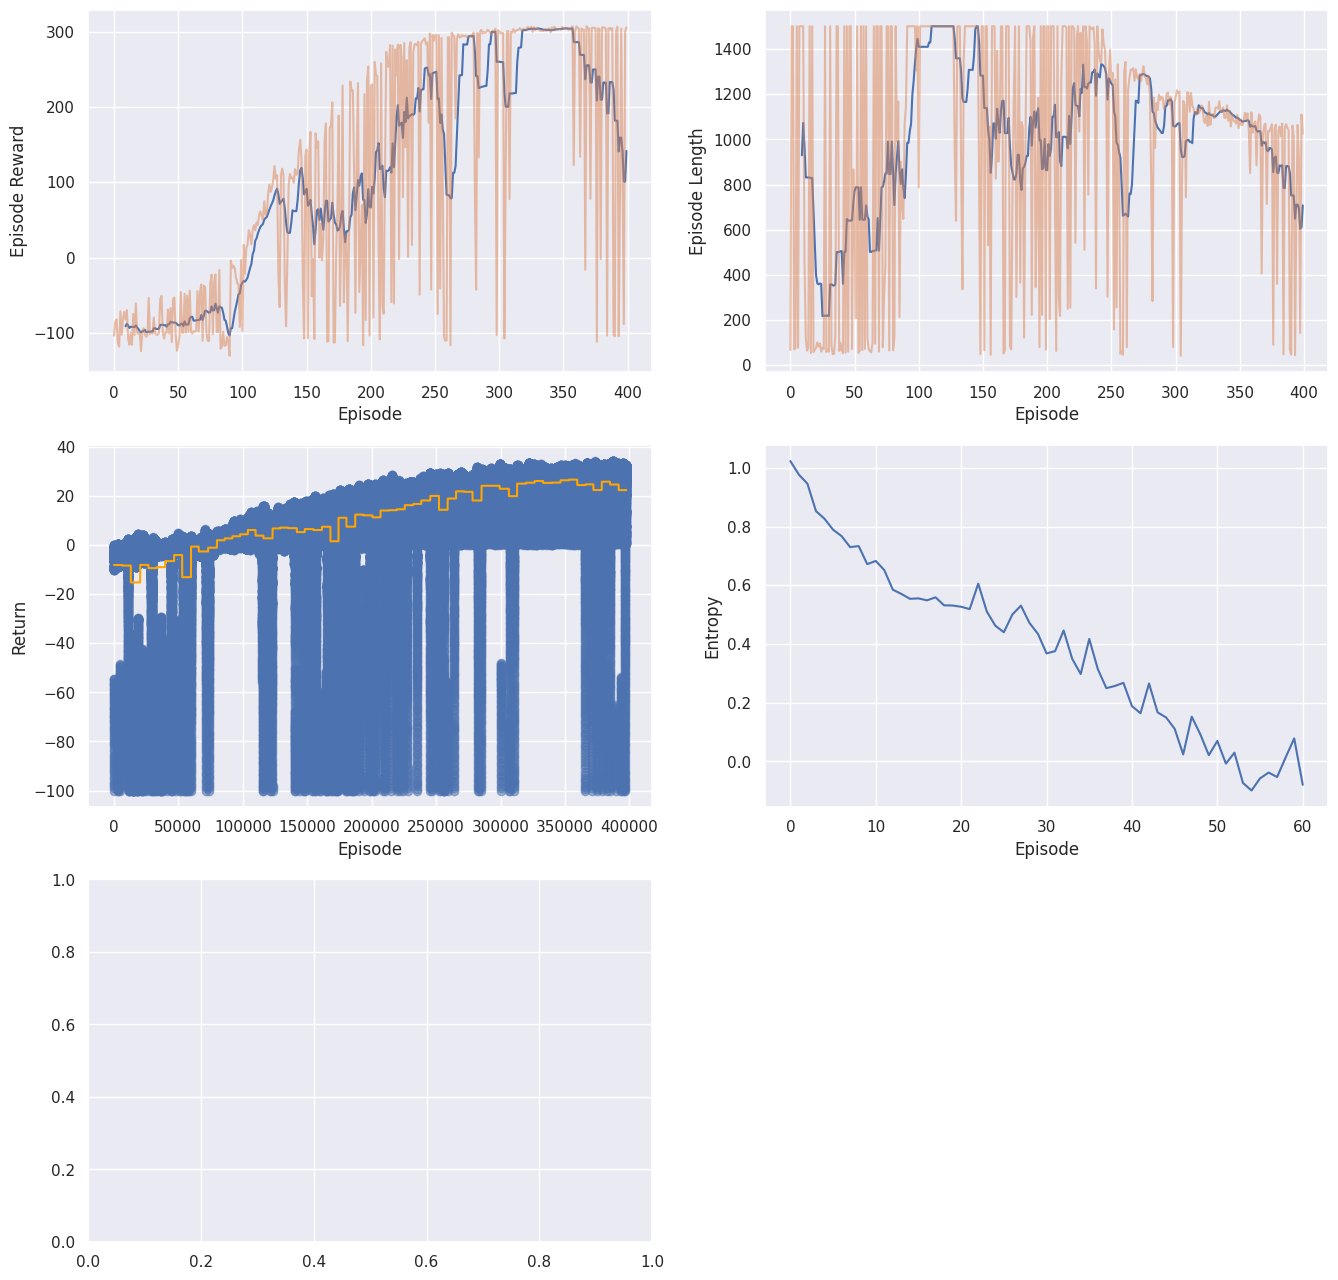

In [214]:
plot_results(runner)

In [218]:
agent.save_onnx_checkpoint()

## Visualize Agent

In [216]:
# load model from checkpoint
agent.resume_checkpoint('ckpts/best-checkpoint.pth')

In [217]:
# run agent in the envrionment
env, _, _ = create_env(logger)
agent.model.eval()
test_environment(env=env, agent=agent)
show_video(logger)

Moviepy - Building video /tf/jku/logdir/2024-06-16T16-17-56/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-16T16-17-56/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-16T16-17-56/videos/rl-video-episode-0.mp4
logdir/2024-06-16T16-17-56/videos


# Demo Evaluations

In [ ]:
agent.load_onnx_checkpoint('demo.onnx')

In [163]:
# run agent in the envrionment
logger = Logger('logdir')
env, _, _ = create_env(logger)
agent.model.eval()
test_environment(env=env, agent=agent, n_steps=500)
show_video(logger)

Moviepy - Building video /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-0.mp4
Moviepy - Building video /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-1.mp4
Moviepy - Building video /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /tf/jku/logdir/2024-06-15T22-34-24/videos/rl-video-episode-2.mp4
logdir/2024-06-15T22-34-24/videos
